# Writeup on Advanced Lane Finding

This is where I address the following steps taken to recognize lane lines on a road:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

This writeup will contain code snippets and images that will help in understanding the process better.

## 1. Camera Calibration

The code for this step is written separately in file camera_calibration.ipynb.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
Corner points for each chess-board image are computed using cv2.findChessboardCorners() and are drawn back on the images using cv2.drawChessboardCorners().  
Now, the camera can be calibrated using objpoints and imgpoints and a given image can be distorted using cv2.undistort(). Further, the mtx and dist parameters are stored in a pickle file so that we can undistort the images for the video.  
Output of undistort on a camera_cal/calibration1.jpg image can be seen below:

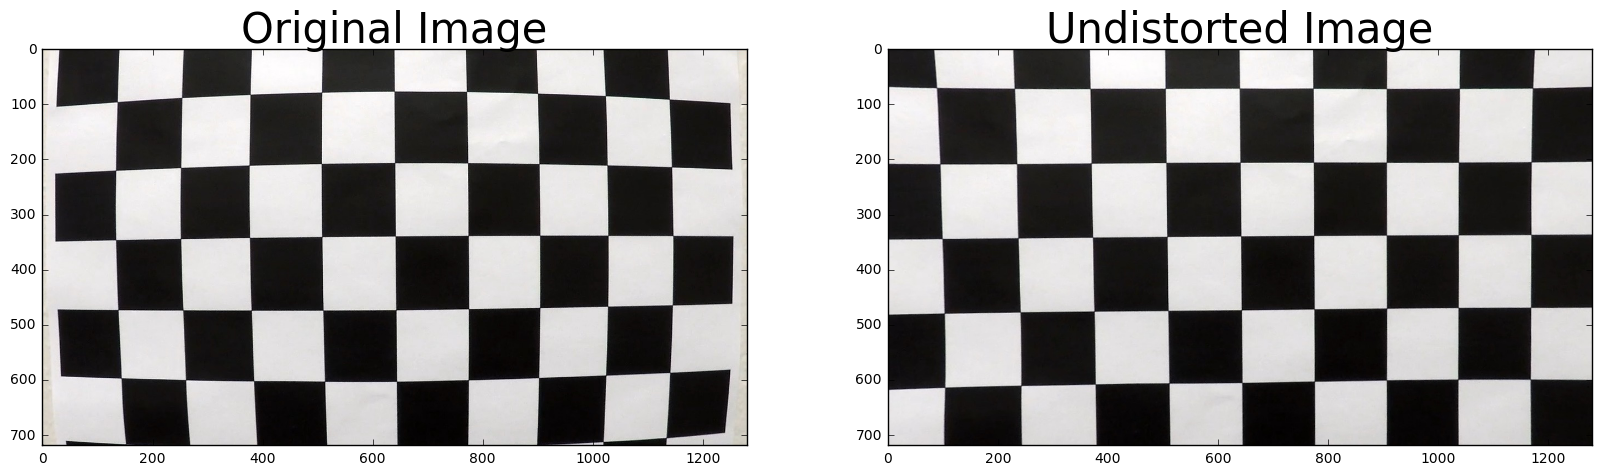

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from main import *
%load_ext autoreload
# Visualize undistortion
plot_2pictures(plt.imread('camera_cal/calibration1.jpg'),
              'Original Image',
              plt.imread('output_images/calibration1_undistored.jpg'),
              'Undistorted Image')


Thus we can see that the image has been calibrated.

## Pipeline (single images)  
### 1. Provide an example of a distortion-corrected image  

The output of all undistorted test images is stored in folder output_images/undistorted_test_images. We can see the effect of undistortion on one of the test images below:

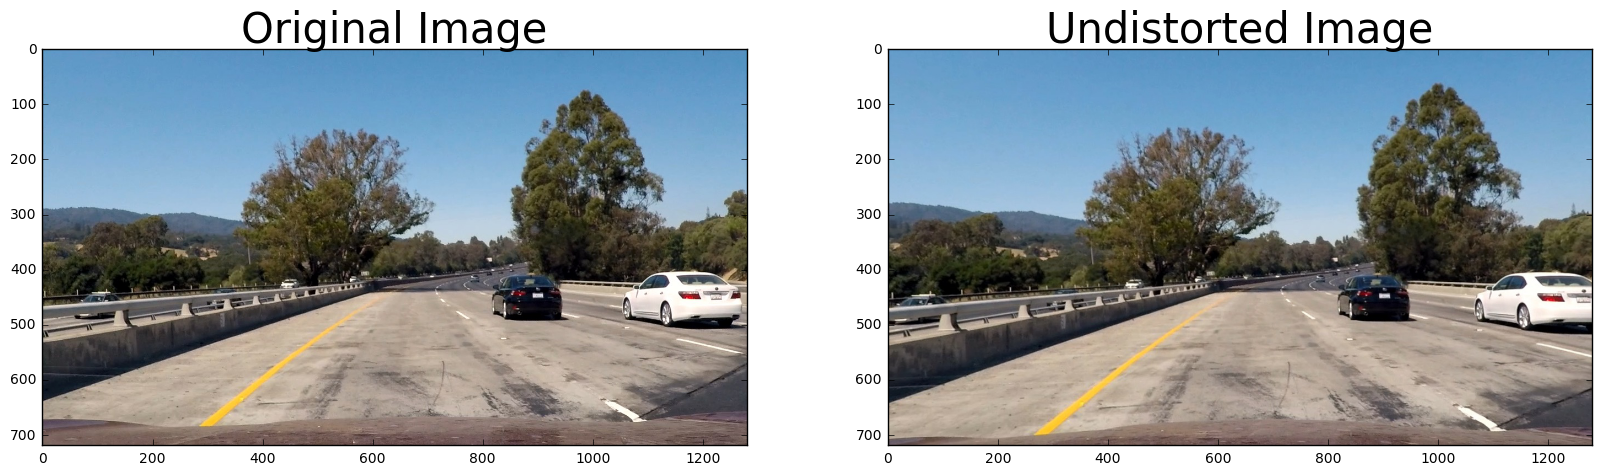

In [2]:
plot_2pictures(plt.imread('test_images/test1.jpg'), 
               'Original Image', 
               plt.imread('output_images/undistorted_test_images/test1_undist1.jpg'),
               'Undistorted Image')

In order to apply distortion correction to test images, I utilized the mtx and dist parameters saved in pickle file during camera calibration. I passed these values to cv2.undistort() function which corrects the distortion in the given image.

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.  
Code for getting the thresholded binary image that can help me find lanes on the road is given in file image_processing.py.   
Function 'yellow_color_finder' finds the yellow color in the image. In HSV color space, I have found the lower and upper range for finding yellow color. cv2.inRange() function returns a binary mask where white (255) pixels represent pixels that fall into the upper and lower limit range and black (0) pixels do not.  
Doing a bitwise_and on this binary image shows only those pixels in the image that have a corresponding white value in the mask.   
Finally, this image is converted to grayscale and thresholded to consider pixels in the given range. This method finds out the yellow lines pretty substantially for the project_video.  

Next is finding white lines, which is pretty straight forward. The image is converted to grayscale and the histogram is equalized so that brightness changes can be dealt with efficiently. This image is thresholded and only the brightest pixels are taken into consideration.  

FInally, I applied sobel in the x-direction i.e. for vertical lines because we are interested in road lines which are verrtical. Using sobel in y-direction added a lot of unnecessary details to the lane finding procedure.  

Function combined_binary_image() calls these functions separately and combines them to return a binary image. We can see the returned image below:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


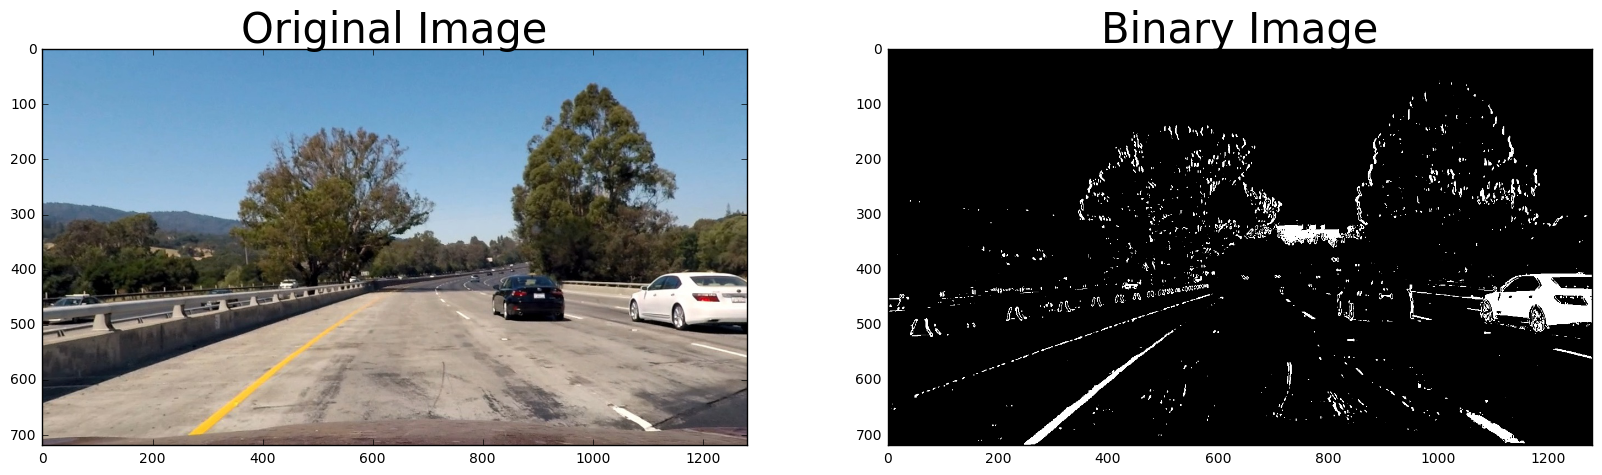

In [3]:
from image_processing import *
%load_ext autoreload
binary_image = combined_binary_image(plt.imread('output_images/undistorted_test_images/test1_undist1.jpg'))
plot_2pictures(plt.imread('output_images/undistorted_test_images/test1_undist1.jpg'), 
               'Original Image',
               binary_image,
               'Binary Image',
              'gray')
# you can also find this image in output_images folder with name binary_thresholded_image.png

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.
Code for perspective transform is also contained in the image_processing.py file in the function get_perspective().  
I choose source and destination coordinates as below:

source coordinates:  
src_coords = np.float32([[width, height - 10],  
                         [0, height - 10],  
                         [546, 460],  
                         [732, 460]])  
destination coordinates:  
dst_coords = np.float32([[width, height],  
                         [0, height],  
                         [0, 0],  
                         [width, 0]])  
                         
where width and height are that of the image and source points belong to the original image while destination points are for the perspective view of the image.  

We can see the effect of perspective transform in the followign image:

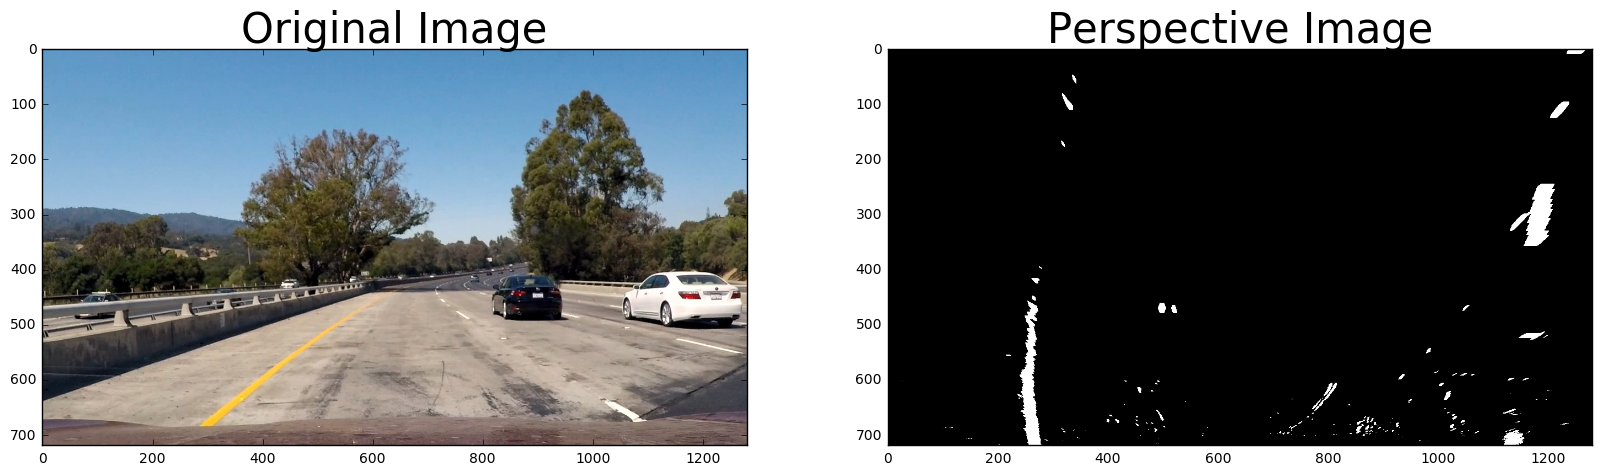

In [4]:
pers_image, Minv = get_perspective(binary_image)
plot_2pictures(plt.imread('test_images/test1.jpg'),
              'Original Image',
              pers_image,
              'Perspective Image',
              'gray')
# you can also find this image in output_images folder under the name perpective1.png

We can see that the two lane lines in the perspective transform are parallel and hence, we can say that the perspective transform works.

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The code for identifying lane line pixels is saved in file lines.py. A class for lines is creted where a line can be either left or right and is an instance of class lines. For every frame in the video/for a given image, the following steps are followed:  
- histogram of half the perspective image is created
- there should be two peaks in the histogram representing the left and right lanes. 
- midpoints of these peaks give us the starting position of the lanes.
- we slide a window of fixed size in vertically upward fashion and in each iteration, find the pixels that are a part of the lane within this window.
- the horizontal position of this window is adjusted depending on the number of pixels found in the window
- we fit a second order polynomial to these left and right line pixels to get a fit of the lines.
- in case one or both of the lines is/are not found, we use the previous values of line fits based on the hypothesis that lanes do not change drastically between two consecutive frames.
- is it for this reason that, we keep record of the previous and current fits for the both left and right lanes


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(720, 0)

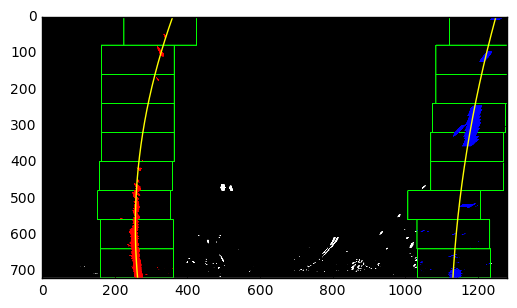

In [6]:
from lines import *
%load_ext autoreload

left_lane = lines.Line()
right_lane = lines.Line()

left_lane, right_lane, out_img = find_new_line(left_lane, right_lane, pers_image)

# Generate x and y values for plotting
ploty = np.linspace(0, pers_image.shape[0]-1, pers_image.shape[0] )
left_fit = left_lane.recent_fit
right_fit = right_lane.recent_fit
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[left_lane.all_y, left_lane.all_x] = [255, 0, 0]
out_img[right_lane.all_y, right_lane.all_x] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# you can also find this figure in folder output_images under the name windows_fit_drawn.png

### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.  
Calculation of radius of curvature in meters is done in function get_roc_and_lane_pos() in lines.py file. The radius of curvature is found by the given formula:  

    roc_meters = ((1 + (2 * fit_meters[0] * y_eval * ym_per_pix + fit_meters[1]) **
                   2) ** 1.5) / np.absolute(2 * fit_meters[0])  
                   
where fit_meters is the 2nd degree polynomial fit to the x and y (in the real space).  

To calculate the distance from center, I first find position of the lane line in the pixels space at the point closest to the car (y=720) by using the previously fit ploynomial. This value is then used in the below formuala:  

deviation = ((right_pos + left_pos)/2. - 1280/2.) * xm_per_pix   

(where xm_per_pix is 3.7/700 meters per pixel in x dimension) to find the deviation of the car from the center. This is based on the hypothesis that the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset we're looking for.

### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.  

Code for this part is provided in the draw() function of file main.py. The lane area as well as radius of curvature and distance from center are shown in the image below:

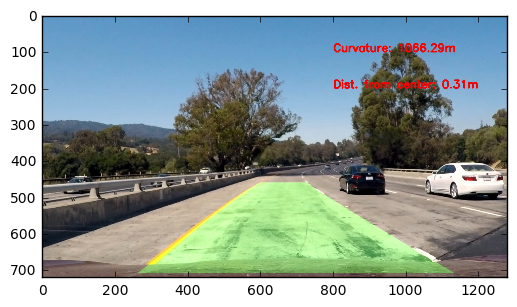

In [7]:
_ = plt.imshow(plt.imread('output_images/result_test1.jpg'))

## Pipeline (Video)
### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).  
My final video can be found at:  
https://youtu.be/yT25TS8DN1Q

### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?  
I felt that working with thresholds manually is not a good idea to detect lane lines. Thresholds are prone to changing conditions and cannot be relied upon. Though my approach works well on the project video, it fails in the challenge videos. While working on this project, experimenting with the thresholds was painful.  
I am currently implementing the sliding window algorithm for all frames and this is making the processing really slow.  
I would also like to save the previous n fits of the lane lines and use their means to get a smoother fit.  
My pipeline is likely to fail in changing condition, like in the challenge video where, the sobel operator detects part of the darker road as an edge. Color thresholds should not be applied in my opinion because they are just too sensitive. One could rather use a CNN to train my network to learn about lane lines.